# Neural network

Let’s now move on to building a functional neural network capable of forecasting temperature. To do this, we first need to choose the most suitable tool for our task. There are several powerful open-source libraries available for developing neural networks, such as Google’s JAX or TensorFlow, and Meta’s PyTorch—all well-equipped for a project of this scope. However, since work with PyTorch had already begun prior to my arrival, we decided to continue using it. PyTorch is a well-established library with extensive documentation and community support. It's also known for being intuitive, supports easy integration with CUDA for faster training, and follows an object-oriented approach where most components are implemented as classes. We will now dive into the core of our project.

## Data management in PyTorch

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import torch
import joblib
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau 
import os
from datetime import datetime

print('Librerías importadas')

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
print(timestamp)

hidden1 = 128
hidden2 = 64
hidden3 = 32
layers = [hidden1, hidden2, hidden3]

learning_rate = 0.001

dropout = 0.2
batch_size = 256


run_suffix = f"{hidden1}_{hidden2}_{hidden3}_{dropout}_{batch_size}_{learning_rate}"

Librerías importadas
20250812_220531


Above, we defined the key parameters of our neural network. It consists of three hidden layers with 128, 64, and 32 neurons, respectively. We also set the learning rate, a crucial parameter that controls how quickly the model updates its weights and how effectively it navigates the cost function landscape.

To prevent the network from overfitting or relying too heavily on a few neurons, we included dropout. Additionally, we specified the batch size, which determines how many data samples are processed together before updating the model's weights.

In [ ]:
print(os.getcwd())
ds = pd.read_csv('../../../WRFTA_v1B.csv')
ds['fecha'] = pd.to_datetime(ds['fecha'])

f = ds.drop(columns = ['fecha', 'estacion', 'QSNOW_0','QSNOW_7','QSNOW_12','hora','dia'])
df = ds.dropna()
print(df.columns)

X = df.drop(columns =['TA','peso'])
Y = df['TA'] 
weights = df['peso']

# We create a directory to save the model and artifacts
run_name = f"WRFTA_{run_suffix}"
run_dir = f"./Modelos/{run_name}/{timestamp}"
os.makedirs(run_dir, exist_ok=True) 

/home/hugo/GitHub/ai-temperature-prediction/NOTEBOOKS


Given that the initial DataFrame contained highly correlated variables, particularly between measurements of the same variable at different altitudes, we chose to work with a new dataset. The new variables are taken from altitude levels that are significantly farther apart, helping to ensure low correlation between them. Below is a brief explanation of the variables used in our dataset:

General Metadata

fecha: Date of the observation.

estacion: Identifier of the weather station.

x, y: Grid coordinates in the model domain.

hora, dia: Hour and day of the observation.

sin_hora, cos_hora, sin_dia, cos_dia: Sine and cosine transformations of hour and day, used to capture cyclical patterns in time.

porcentaje_mar: Percentage of the grid cell covered by sea.

altura: Elevation (altitude) of the location.

Geolocation

XLAT: Latitude of the observation point.

XLONG: Longitude of the observation point.

Surface-Level Meteorological Variables
PSFC: Surface pressure.

T2: Air temperature at 2 meters above the ground.

PREC: Precipitation amount.

Atmospheric Variables at Different Altitudes
These variables are measured at three different vertical levels: level 0 (near the surface), level 7 (mid-atmosphere), and level 12 (higher altitude).

Each level includes the following variables:

z_[level]: Height of the atmospheric level.

QVAPOR_[level]: Water vapor mixing ratio.

QRAIN_[level]: Rainwater mixing ratio.

QSNOW_[level]: Snow mixing ratio.

QGRAUP[level]: Graupel (ice pellet) mixing ratio.

U_[level], V_[level]: Wind components in the east-west (U) and north-south (V) directions.

T_[level]: Temperature at the given level.

Target Variable
TA: The target temperature we aim to predict.

In [ ]:
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
# Escalado de salida (Y)S
scaler_Y = StandardScaler()
Y_scaled = scaler_Y.fit_transform(Y.values.reshape(-1, 1)).flatten()
# Es necesario guardar los reescalados para después cargarlos en el código modelo_entrenado.py y poder reescalar así los valores finales.
joblib.dump(scaler_X, os.path.join(run_dir, 'scaler_XWRF.save'))
joblib.dump(scaler_Y, os.path.join(run_dir, 'scaler_YWRF.save'))

# Separamos los datos en conjuntos de entrenamiento y de testeo diferentes para ver si realmente está aprendiendo la red.
X_train, X_val, Y_train, Y_val = train_test_split(
    X_scaled, Y_scaled, test_size=0.2, random_state=42
)

np.save(os.path.join(run_dir,'featuresWRF.npy'), X_scaled)
np.save(os.path.join(run_dir,'targetsWRF.npy'), Y_scaled)

np.save(os.path.join(run_dir,'features_trainWRF.npy'), X_train)
np.save(os.path.join(run_dir,'targets_trainWRF.npy'), Y_train)

np.save(os.path.join(run_dir,'features_valWRF.npy'), X_val)
np.save(os.path.join(run_dir,'targets_valWRF.npy'), Y_val)

We normalize the data using the StandardScaler() function, which standardizes each feature by removing the mean and scaling to unit variance. In other words, it subtracts the mean and divides by the standard deviation for each column.

After normalization, the dataset is split into two subsets:

80% for training the model

20% for validating its performance

This approach is common in neural network training, as it helps ensure the model is not simply memorizing the data but is genuinely learning to make accurate predictions—in our case, predicting temperature.

In [ ]:
import torch

class DATA(Dataset):
    def __init__(self, path_x, path_y):
        self.features = np.load(path_x) 
        self.targets = np.load(path_y) 

    def __len__(self): 
        return len(self.features) 

    def __getitem__(self,idx):
        x = torch.from_numpy(self.features[idx].copy()).float()
        y = torch.tensor(self.targets[idx], dtype=torch.float32) 
        return x, y

In this section, we define a custom PyTorch dataset class called DATA, which inherits from torch.utils.data.Dataset. This allows PyTorch to treat our data as a dataset.

__init__: Loads features and targets from .npy files using NumPy.

__len__: Returns the number of samples in the dataset.

__getitem__: Returns one sample (input and target) as PyTorch tensors.

In [ ]:
train_dataset = DATA(
    os.path.join(run_dir, 'features_trainWRF.npy'), 
    os.path.join(run_dir, 'targets_trainWRF.npy'),
    )
    
val_dataset = DATA(
    os.path.join(run_dir, 'features_valWRF.npy'), 
    os.path.join(run_dir, 'targets_valWRF.npy'),
    )

dataset = DATA(
    os.path.join(run_dir, 'featuresWRF.npy'), 
    os.path.join(run_dir, 'targetsWRF.npy'),
    )

We then create three different DATA instances assigning its features and targets paths. This allows PyTorch to treat our data as a dataset.

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True) 
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
loader = DataLoader(dataset, batch_size = batch_size, shuffle = False) 

total_batches = len(train_loader) 
print(f'Número de batches: {total_batches}')

Lastly, we use DataLoader to efficiently load data in batches: 

train_loader: Loads training data in shuffled batches.

val_loader: Loads validation data without shuffling.

loader: Loads the full dataset, also without shuffling.

## Neural network

In this section, we define a fully connected neural network using PyTorch by creating a class that inherits from nn.Module. The model takes the number of input features (input_size) as a parameter and is composed of three hidden layers with ReLU activation functions and dropout layers in between. These dropout layers help prevent overfitting by randomly disabling a fraction of neurons during training. The architecture is built using nn.Sequential, which stacks the layers in the order they are applied.

Each hidden layer reduces the dimensionality of the data and learns more abstract representations. The final layer consists of a single neuron that outputs the predicted temperature given an initial data array. The forward() method defines how the input tensor flows through the network and returns the final prediction.

In [ ]:
import torch.nn as nn

class RedNeuronal(nn.Module):
    def __init__(self, input_size):
        super(RedNeuronal, self).__init__()
        self.red = nn.Sequential( 
            nn.Linear(input_size,hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1,hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden2,hidden3),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden3,1),  # hidden 3
        )

    def forward(self,x):
        return self.red(x)

In [ ]:
input_size = X_scaled.shape[1] 
print(f'input_size: {input_size}')

model = RedNeuronal(input_size)
criterion = torch.nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

Once the model is defined, we extract the input size (i.e., the number of features) directly from the DataFrame to configure the input layer accordingly. After that, we set up three key components from PyTorch that are essential for training: the loss function, the optimizer, and the learning rate scheduler.

criterion defines the loss function that measures how well the model performs. In our case, we use Mean Squared Error (MSE), which is commonly used for regression tasks.

optimizer is the algorithm that adjusts the model’s weights to minimize the loss. We use a built-in optimizer from PyTorch (Adam), which updates the weights to improve temperature predictions over time.

scheduler dynamically adjusts the learning rate during training. Since our model has a large number of parameters (e.g., weights and biases across layers of sizes 128, 64, and 32), the cost function’s surface is complex with many valleys. Initially, the optimizer takes larger steps to explore the space, but as it approaches a minimum, the scheduler reduces the learning rate (by a factor of 0.5 after 3 stagnant epochs in our case). This strategy helps the model converge more precisely to an optimal solution without overshooting.

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience            
        self.min_delta = min_delta          
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # Se reinicia porque hay mejora
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopper = EarlyStopping(patience=10, min_delta=0.001)


The final class we define is EarlyStopping, an essential component for training our neural network efficiently. Its purpose is to stop the training process if the model does not show meaningful improvement after a certain number of consecutive epochs. Specifically, if the validation loss does not improve by at least min_delta = 0.001 over 10 consecutive epochs, training will be halted. This helps prevent overfitting and saves computational resources by avoiding unnecessary training once the model has stopped learning and achieved a locally optimal configuration. 

Now we shall move onto the actual training process of our neural network and how we implemented it using PyTorch. Since this is the core of our project we shall explain it carefully.

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer):
    epoch_loss = 0
    for batch_idx, (x_batch, y_batch, weights_batch) in enumerate(train_loader):
        pred = model(x_batch).squeeze()
        losses = criterion(pred, y_batch)
        loss = losses.sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    return epoch_loss / len(train_loader)

Above, we showed the training function. It receives the model (RedNeuronal(input_size)), the training loader (which contains the training dataset shuffled and split into batches of size 256), the loss criterion (MSE), and the optimizer (Adam).

Each batch consists of 256 data samples, each containing features and targets. For every sample in the batch, the neural network predicts an output from the features, and then we calculate the loss using the MSE function by comparing the prediction with the actual observation. After processing all 256 samples in the batch, we compute the average loss, which represents the overall error for that batch. A higher loss means the model’s predictions were less accurate.

Once the loss for the batch is calculated, the optimizer computes the gradient of this loss with respect to the model’s parameters and updates the weights to minimize the error, following the path of steepest descent.

This entire process is repeated for all batches in the training loader during each epoch. By dividing the total loss accumulated over all batches by the number of batches, we obtain the average training loss for the epoch.

The training continues for as many epochs as specified by the EarlyStopping function or until the maximum number of epochs is reached.

In [ ]:
def validate(model, val_loader, criterion, scaler_Y):
    model.eval()
    val_loss = 0
    preds_celsius = []
    targets_celsius = []

    with torch.no_grad():
        for x_val, y_val in val_loader:
            pred_val = model(x_val).squeeze()
            loss = criterion(pred_val, y_val).mean()
            val_loss += loss.item()

            pred_kelvin = scaler_Y.inverse_transform(pred_val.cpu().numpy().reshape(-1, 1))
            target_kelvin = scaler_Y.inverse_transform(y_val.cpu().numpy().reshape(-1, 1))
            preds_celsius.extend((pred_kelvin - 273.15).flatten())
            targets_celsius.extend((target_kelvin - 273.15).flatten())

    avg_val_loss = val_loss / len(val_loader)
    MAE_celsius = np.mean(np.abs(np.array(preds_celsius) - np.array(targets_celsius)))

    return avg_val_loss, MAE_celsius

Now we move on to the validation process. This step is crucial to determine whether the neural network is truly learning or just memorizing the training data. During validation, we turn off gradients because we only want to evaluate the model’s performance, not update its weights. For each data sample in the validation dataset, we compute the predicted values and then calculate the total loss. We obtain the average validation loss by dividing this total by the number of batches in the validation loader. To better understand how well the model is performing in real-world terms, we rescale the predicted and observed temperatures back to their original units and convert them to Celsius. This gives us a physical measure of error that is easier to interpret.

We then calculate the Mean Absolute Error (MAE) in Celsius and print it alongside the average validation loss at each validation step. Since the dataset was initially rescaled, the validation loss itself does not carry a direct physical meaning, it only indicates whether the model’s performance is improving or worsening. That’s why the MAE in Celsius is important: it provides an approximate measure of the model’s expected error when forecasting the entire dataset.

In [ ]:
num_epochs = 60
best_val_loss = float('inf')

for epoch in range(num_epochs):
    avg_loss = train_one_epoch(model, train_loader, criterion, optimizer)
    avg_val_loss, MAE_celsius = validate(model, val_loader, criterion, scaler_Y)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = f"./Modelos/{run_name}/{timestamp}/WRFTA_{run_suffix}.pt"
        torch.save(model.state_dict(), best_model_path)

    # Scheduler checks the average loss
    scheduler.step(avg_val_loss) 
    # Early stopper checks the average loss
    early_stopper(avg_val_loss) 

    model.train()
    # Printing the metrics for each epoch
    print(f"Epoch {epoch+1}, Loss entrenamiento: {avg_loss:.4f}, Loss validación (escalado): {avg_val_loss:.4f}, MAE validación (°C): {MAE_celsius:.4f}")
    
    # Early stopping check
    if early_stopper.early_stop:
        print(f"Parada temprana en la época {epoch+1}")
        break

# Loading the best model
print('Cargando el mejor modelo guardado...')
model.load_state_dict(torch.load(best_model_path))
print('Comenzando la predicción...')
model.eval()
all_preds_scaled = []
all_targets_scaled = []

# We use the best model to make predictions on the entire dataset
with torch.no_grad():
    for x_batch, y_batch in loader:
        y_pred = model(x_batch).squeeze()
        all_preds_scaled.append(y_pred.numpy())
        all_targets_scaled.append(y_batch.numpy())
        

Once the training and validation functions are defined, we can begin training our neural network. The process is straightforward: in each epoch, we train the model and validate its performance, saving the configuration that achieves the best average validation loss. Meanwhile, the scheduler and early stopper monitor the network’s progress, adjusting the learning rate or stopping the process entirely if necessary.

After the training loop finishes (EarlyStopper summoned or maximum num_epochs achieved), we load the best saved configuration and use it to generate predictions for the entire dataset.

In [ ]:
all_preds_scaled = np.concatenate(all_preds_scaled).reshape(-1, 1)
all_targets_scaled = np.concatenate(all_targets_scaled).reshape(-1, 1)

y_pred_real = scaler_Y.inverse_transform(all_preds_scaled).flatten()
y_test_real = scaler_Y.inverse_transform(all_targets_scaled).flatten()

df_resultados = pd.DataFrame({
    'y_pred_C': y_pred_real - 273.15, 
    'TA_C': y_test_real - 273.15 
})

print(f'Error medio absoluto (MAE): {(np.mean(np.abs(y_test_real - y_pred_real))):.4f}')

print(f'ds.columns: {ds.columns}')
print(f'ds.shape {ds.shape}')
print(f'df_resultados.columns: {df_resultados.columns}')
print(f'df_resultado.shape: {df_resultados.shape}')

ds = ds.reset_index(drop=True)  
df = pd.concat([ds[['fecha']], df_resultados], axis=1)

# Begin plotting
print('Inicializando Plot')
df['fecha'] = pd.to_datetime(df['fecha'])
df['dia_fecha'] = df['fecha'].dt.normalize()
df['mes'] = df['fecha'].dt.to_period('M')

# Group errors by day to get daily extremes (max and min of the day)
extremos_diarios = df.groupby('dia_fecha').agg({
    'TA_C': ['min', 'max'],
    'y_pred_C': ['min', 'max'],
    'mes': 'first'
}).reset_index()

# Renombrar columnas
extremos_diarios.columns = ['dia_fecha', 'TA_min', 'TA_max', 'y_pred_min', 'y_pred_max', 'mes']

# Extreme temperatures differences
extremos_diarios['diff_max'] = np.abs(extremos_diarios['TA_max'] - extremos_diarios['y_pred_max'])
extremos_diarios['diff_min'] = np.abs(extremos_diarios['TA_min'] - extremos_diarios['y_pred_min'])

df_diffs_mensuales = extremos_diarios.groupby('mes')[[
    'diff_max', 'diff_min'
]].mean().reset_index()

# MAE 
df_diario = df.groupby('dia_fecha').agg({ 
    'TA_C': 'mean',
    'y_pred_C': 'mean' 
}).reset_index()

df_diario['mes'] = df_diario['dia_fecha'].dt.to_period('M')

df_error_mensual = df_diario.groupby('mes').apply(
    lambda x: pd.Series({
        'MAE_diaria': np.mean(np.abs(x['y_pred_C'] - x['TA_C'])),
    })

).reset_index()

# Merge monthly differennces
df_mensual = df_diffs_mensuales.merge(df_error_mensual, on='mes') 

# Plot
plt.figure(figsize=(14, 6))

plt.plot(df_mensual['mes'].astype(str), df_mensual['diff_max'], label='MAE Tmáx', marker='s', color='red')
plt.plot(df_mensual['mes'].astype(str), df_mensual['diff_min'], label='MAE Tmín', marker='s', color='blue')
plt.plot(df_mensual['mes'].astype(str), df_mensual['MAE_diaria'], label='MAE Tmedia', marker='s', color='cyan')

plt.axhline(0, linestyle='--', color='gray', linewidth=1)

plt.xlabel('Mes')
plt.ylabel('Diferencia temperatura extrema (°C)')
plt.title('Promedio mensual de la diferencia entre temperaturas extremas observadas y predichas')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Prints
mae_global = np.mean(np.abs(df['TA_C'] - df['y_pred_C']))

print(f"MAE {mae_global:.3f}")
mae_max = np.mean(df_mensual["diff_max"])
mae_min = np.mean(df_mensual["diff_min"])
print(f'MAE_máximas {mae_max}')
print(f'MAE_mínimas {mae_min}')

plt.savefig(f'{run_suffix}_RED_diferencias_extremos_diarios_promedio_mensual.png', dpi=300)

# Boxplot
import seaborn as sns

# Tmax
plt.figure(figsize=(14, 6))
sns.boxplot(x=extremos_diarios['mes'].astype(str), y=extremos_diarios['diff_max'], color='red')
plt.title('Distribución del error absoluto en Tmáx por mes')
plt.xlabel('Mes')
plt.ylabel('Error absoluto (°C)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{run_suffix}_boxplot_Tmax.png', dpi=300)

# Tmin
plt.figure(figsize=(14, 6))
sns.boxplot(x=extremos_diarios['mes'].astype(str), y=extremos_diarios['diff_min'], color='blue')
plt.title('Distribución del error absoluto en Tmín por mes')
plt.xlabel('Mes')
plt.ylabel('Error absoluto (°C)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{run_suffix}_boxplot_Tmin.png', dpi=300)

# T average daily
df_diario['error_abs'] = np.abs(df_diario['TA_C'] - df_diario['y_pred_C'])

plt.figure(figsize=(14, 6))
sns.boxplot(x=df_diario['mes'].astype(str), y=df_diario['error_abs'], color='cyan')
plt.title('Distribución del error absoluto en Tmedia diaria por mes')
plt.xlabel('Mes')
plt.ylabel('Error absoluto (°C)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{run_suffix}_boxplot_Tmedia.png', dpi=300)

## Results

Below, we present a boxplot comparing the deviations of the predictions from our best-trained neural network with those of the classic WRF model. In the plot, each box spans the 25th to 75th percentiles of the data, while the black line inside the box represents the median (50th percentile) for each model and for extreme temperatures. The lines extending from the boxes are the whiskers, which indicate the range of typical deviations, excluding outliers.

As illustrated, the deviations produced by the neural network are generally smaller than those of the WRF model. This demonstrates the neural network’s flexibility, as it can more accurately predict both unusually high and low temperatures, whereas the WRF model tends to struggle with these extremes. 

We demonstrated that a neural network can effectively forecast temperature and, in many cases, outperform the traditional WRF model, particularly when predicting extreme values. The flexibility of the neural network allows it to adapt to complex patterns in the data, offering more accurate and reliable predictions. Future improvements could include weighting extreme temperatures, incorporating additional temporal or geographic features, and experimenting with larger datasets to further enhance performance. Overall, this project highlights the potential of neural networks as a powerful tool for weather forecasting and opens the door to more advanced, data-driven approaches in meteorology.

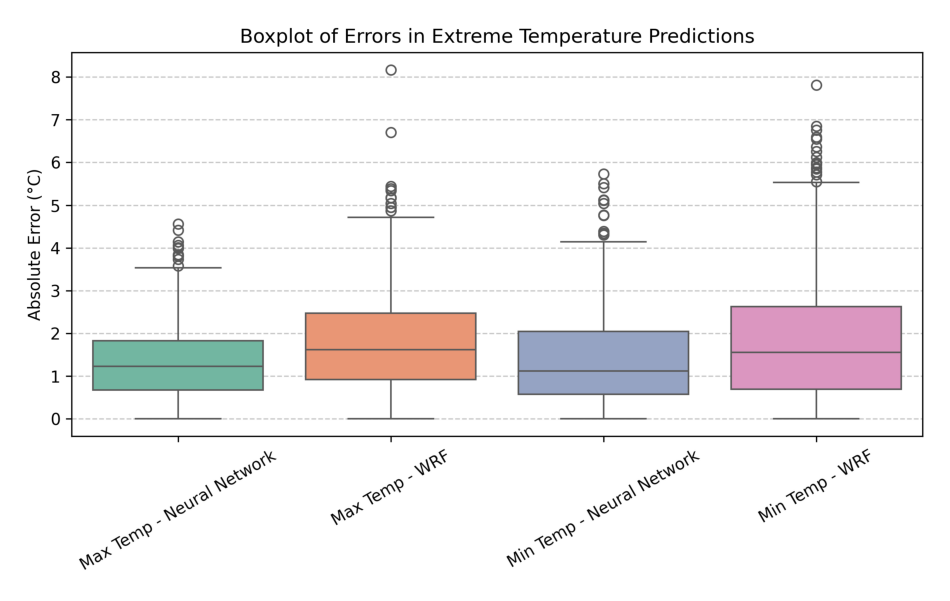

In [18]:
import os 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

boxplot_dir = "../../../experimento/boxplot_errors.png"
boxplot = mpimg.imread(boxplot_dir)

plt.figure(figsize=(12, 12))
plt.imshow(boxplot)
plt.axis('off')  
plt.show()